In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pathlib

import PaSDqc

%matplotlib inline

In [2]:
p = pathlib.Path("../data/Lodato_2015/1465/psd/")
f_list = sorted(p.glob("*.chroms.spec"))
sample_list = [f.name.split('.chroms.spec')[0] for f in f_list]
psd_list = [PaSDqc.PSDTools.SamplePSD(pd.read_table(str(f), index_col=0), name=f.name) for f in f_list]

In [3]:
j_list = [psd.KL_div_by_chrom() for psd in psd_list]
df_chrom = PaSDqc.extra_tools.summarize_KL_div_by_chrom(j_list, sample_list)

In [4]:
ind = j_list[0].index.astype(int)
df_kl = pd.DataFrame(np.array(j_list).T, columns=sample_list, index=ind)

In [5]:
df_kl_sort = df_kl.sort_index()
df_kl_sort['chrom'] = df_kl_sort.index

In [6]:
df_kl_melt = pd.melt(df_kl_sort, id_vars='chrom')

In [7]:
df_kl_melt[0:5]
df_kl_melt['Classification'] = 'Pass'
df_kl_melt.loc[df_kl_melt.chrom.isin([15, 16, 17, 19, 20, 21, 22]), 'Classification']='Fail'

In [9]:
df_cn = pd.read_table("1465_CN.txt", index_col=0)

In [10]:
df_aut = df_cn.iloc[:-2, :-2]
df_aut.index = df_aut.index.astype(int)
df_aut_sort = df_aut.sort_index()

df_bulk = df_cn.iloc[:-2, -2:]
df_bulk.index = df_bulk.index.astype(int)
df_bulk_sort = df_bulk.sort_index()

In [11]:
cn_avg = df_aut_sort.mean(axis=1)
cn_se = df_aut_sort.std(axis=1)

In [12]:
sns.set_context("poster")
sns.set_style("ticks", {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})

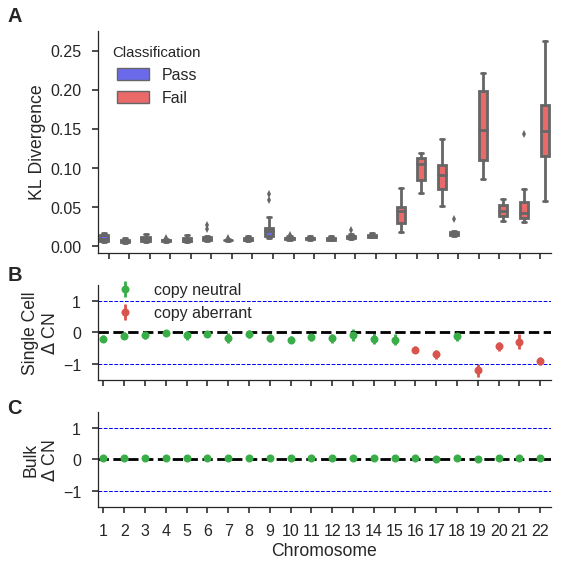

In [13]:
f = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0:2])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])

# Boxplot of KL divergences
sns.boxplot(x='chrom', y='value', hue='Classification', data=df_kl_melt, palette='seismic', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('KL Divergence')
ax0.set_xticklabels([])

# Copy number of Single Cells
colors = ['green' if val>-0.26 else 'red' for val in cn_avg]
chrom = df_aut_sort.index

ax1.plot((0.75, 22.5), (1, 1), 'b--', lw=1)
ax1.plot((0.75, 22.5), (-1, -1), 'b--', lw=1)
ax1.plot((0.75, 22.5), (0, 0), 'k--')
ax1.errorbar(chrom[(cn_avg>-0.26).as_matrix()], cn_avg[cn_avg>-0.26], 2*cn_se[cn_avg>-0.26], fmt='o', ms=8, color=sns.xkcd_rgb['medium green'], label='copy neutral')
ax1.errorbar(chrom[(cn_avg<-0.26).as_matrix()], cn_avg[cn_avg<-0.26], 2*cn_se[cn_avg<-0.26], fmt='o', ms=8, color=sns.xkcd_rgb['pale red'], label='copy aberrant')
ax1.set_xticks(np.arange(1, 23))
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlim(0.75, 22.5)
ax1.set_yticks([-1, 0, 1])
ax1.set_ylabel("Single Cell\n$\Delta$ CN")
ax1.set_xticklabels([])
ax1.legend(loc=(0.01, 0.56))

# Copy number from bulk
ax2.plot((0.75, 22.5), (1, 1), 'b--', lw=1)
ax2.plot((0.75, 22.5), (-1, -1), 'b--', lw=1)
ax2.plot((0.75, 22.5), (0, 0), 'k--')
ax2.plot(chrom, df_bulk_sort.iloc[:, 0], 'o', ms=8, color=sns.xkcd_rgb['medium green'])
ax2.set_xticks(np.arange(1, 23))
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlim(0.75, 22.5)
ax2.set_yticks([-1, 0, 1])
ax2.set_xlabel("Chromosome")
ax2.set_ylabel("Bulk\n$\Delta$ CN")

# Plot layout
sns.despine(top=True)

f.text(0.01, 0.98, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.53, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.3, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
plt.tight_layout()